## Visualizing Heatmaps of Class Activation

Heatmaps of class activations are very helpful in identifying which parts of an image led the CNN to the final classification. It becomes very important when analyzing misclassified data.

We are going to use an implementation of Class Activation Map (CAM) that was used in the paper, [**"Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"**](https://arxiv.org/abs/1610.02391)


### Loading VGG16 with pretrained weights

In [1]:
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
import tensorflow as tf

model = tf.keras.models.load_model("mango_classifier_v1.1_model.model")



Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### Loading our test image of a Tiger

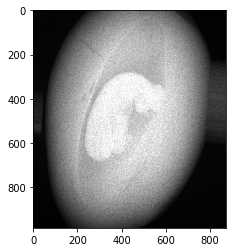

In [2]:
img_path = 'bs.4002.jpg'
imSize = 64
img1 = image.load_img(img_path)
plt.imshow(img1);

img = image.load_img(img_path, target_size=(imSize, imSize))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
#x = preprocess_input(x)

### Getting our VGG16 ImageNet Prediction for the input image

In [3]:
preds = model.predict(x)
if preds[0][0] == 1:
    prediction = 'Good Seed'
else:
    prediction = 'Bad Seed'
print('Predicted:', prediction)

Predicted: Bad Seed


### Getting the class index

In [4]:
class_id = np.argmax(preds[0])
class_id

0

In [5]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total para

### Output the feature map of the block5_conv3 layer, the last convolutional layer in VGG16

In [9]:
pred_output = model.output[:, class_id]

last_conv_layer = model.get_layer('conv2d_2')

# Gradients of the Tiger class wrt to the block5_conv3 filer
grads = K.gradients(pred_output, last_conv_layer.output)[0]

# Each entry is the mean intensity of the gradient over a specific feature-map channel 
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# Accesses the values we just defined given our sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# Values of pooled_grads_value, conv_layer_output_value given our input image
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature-map array by the 'importance' 
# of this channel regarding the input image 
for i in range(512):
    #channel-wise mean of the resulting feature map is the Heatmap of the CAM
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

FailedPreconditionError: Error while reading resource variable conv2d_2/bias from Container: localhost. This could mean that the variable was uninitialized. Not found: Container localhost does not exist. (Could not find resource: localhost/conv2d_2/bias)
	 [[{{node conv2d_2/BiasAdd/ReadVariableOp}}]]
	 [[{{node strided_slice_7}}]]

### Ploting out Heat-Map

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

### Using OpenCV to Overlay the heatmap onto our input image

In [ ]:
import cv2

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

save_img_path = 'tiger_cam3.jpg'

cv2.imwrite(save_img_path, superimposed_img)

img1 = image.load_img(save_img_path)
plt.imshow(img1);